In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification
from PIL import Image
import yaml
import random
from tqdm import tqdm
import torch.nn.functional as F

# === Загрузка параметров ===
with open('parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# === Установка сидов ===
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# === Устройство ===
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")

# === Загрузка модели ===
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=3)
checkpoint_path = "checkpoints/cosin/cosin_vit_fold1.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# === Датасет только для класса 0 ===
class FundusDatasetClass0(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe[dataframe['true_label'] == 0].reset_index(drop=True)
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        img_path = os.path.join(self.root_dir, '0', img_name)
        image = Image.open(img_path).convert("RGB")
        transform = get_transform_pipeline(self.config)
        image = transform(image)
        return image, img_name

def get_transform_pipeline(config):
    transform_list = []
    transform_list.append(transforms.Resize(config['dataset']['image_size']))
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])])
    return transforms.Compose(transform_list)

# === Загружаем старый train_df ===
train_df = pd.read_csv('D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_all_image.csv')
root_dir = 'D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_old'

# === Только класс 0 ===
dataset_0 = FundusDatasetClass0(train_df, root_dir=root_dir, config=config)
loader_0 = DataLoader(dataset_0, batch_size=config['training']['batch_size'], shuffle=False)

# === Считаем энтропии ===
entropy_list = []
image_names = []

with torch.no_grad():
    for images, names in tqdm(loader_0, desc="Вычисление энтропий"):
        images = images.to(device)
        outputs = model(pixel_values=images)
        probs = F.softmax(outputs.logits, dim=1)
        
        entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)  # Энтропия
        entropy_list.extend(entropy.cpu().numpy())
        image_names.extend(names)

# === В DataFrame ===
entropy_df = pd.DataFrame({
    'image_name': image_names,
    'entropy': entropy_list
})

# === Сортируем по энтропии (по убыванию) и оставляем 6260 самых "сложных" изображений ===
entropy_df = entropy_df.sort_values(by='entropy', ascending=False).reset_index(drop=True)
selected_df = entropy_df.iloc[:6260]

print(f"Отобрано изображений: {len(selected_df)}")

d:\dataset\dataset_create\pythonProject\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Вычисление энтропий: 100%|██████████| 1180/1180 [45:55<00:00,  2.33s/it]

Отобрано изображений: 6260


In [ ]:
# === Сохраняем новый датасет класса 0 ===
save_path = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/hard_0/train_selected_class0.csv"
selected_df['true_label'] = 0
selected_df.to_csv(save_path, index=False)

print(f"Новый датасет сохранён: {save_path}")

Новый датасет сохранён: D:/dataset/_eyepacs/data/filtered_data_with_cosine/typical/train_selected_class0.csv


C:\Users\acede\AppData\Local\Temp\ipykernel_9800\2684080029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['true_label'] = 0


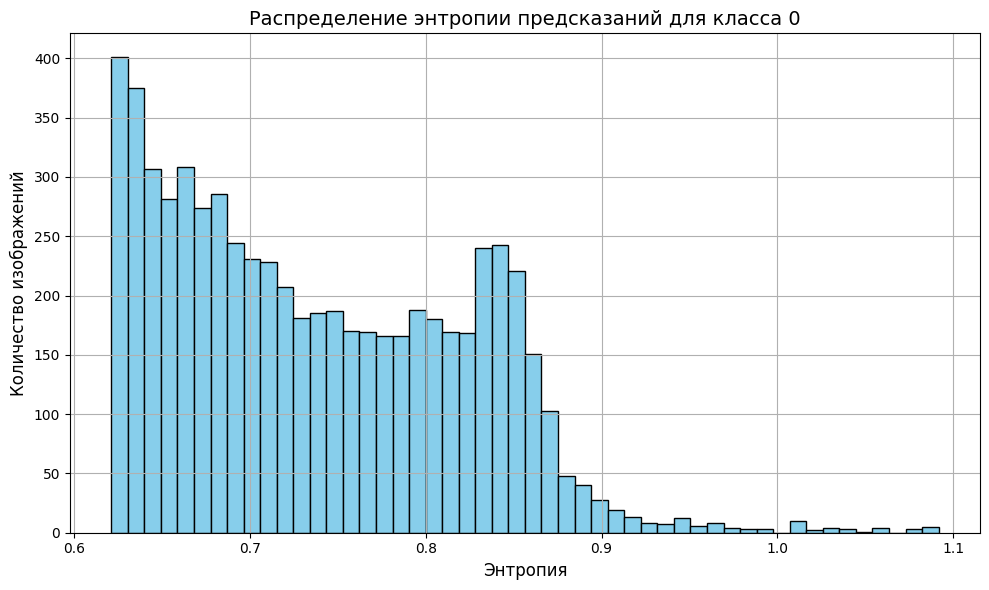

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Построение гистограммы распределения энтропии
plt.figure(figsize=(10, 6))
plt.hist(selected_df['entropy'], bins=50, color='skyblue', edgecolor='black')
plt.title("Распределение энтропии предсказаний для класса 0", fontsize=14)
plt.xlabel("Энтропия", fontsize=12)
plt.ylabel("Количество изображений", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# Загрузка списка выбранных изображений
entropy_df = pd.read_csv("D:/dataset/_eyepacs/data/filtered_data_with_cosine/hard_0/train_selected_class0.csv")

top_entropy_df = entropy_df.sort_values(by='entropy', ascending=False).head(6260)

old_dir = 'D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_old/0'
target_dir = 'D:/dataset/_eyepacs/data/filtered_data_with_cosine/hard_0/train/0'
os.makedirs(target_dir, exist_ok=True)

# Список изображений
selected_images = set(top_entropy_df['image_name'])

# Копирование
for filename in tqdm(os.listdir(old_dir)):
    if filename in selected_images:
        shutil.copy2(os.path.join(old_dir, filename), os.path.join(target_dir, filename))

100%|██████████| 18867/18867 [00:14<00:00, 1303.62it/s]


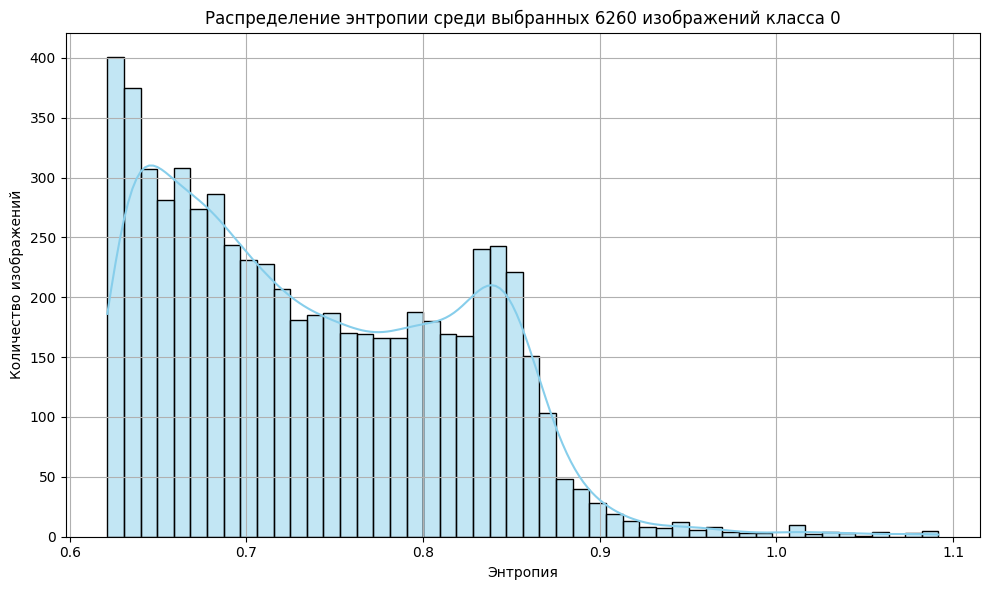

In [8]:
import seaborn as sns
# Построение гистограммы

top_entropy_df = entropy_df.sort_values(by='entropy', ascending=False).head(6260)

plt.figure(figsize=(10, 6))
sns.histplot(top_entropy_df['entropy'], bins=50, kde=True, color='skyblue')
plt.title("Распределение энтропии среди выбранных 6260 изображений класса 0")
plt.xlabel("Энтропия")
plt.ylabel("Количество изображений")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import os
import pandas as pd
from tqdm import tqdm

# Путь к новой папке
base_dir = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/hard_0/train"

# Список для записи информации
records = []

# Проходим по каждому классу (0, 1, 2)
for class_label in ['0', '1', '2']:
    class_dir = os.path.join(base_dir, class_label)
    if not os.path.exists(class_dir):
        print(f"Папка не найдена: {class_dir}")
        continue
    for img_name in tqdm(os.listdir(class_dir), desc=f"Класс {class_label}"):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):  # Только картинки
            records.append({
                'image_name': img_name,
                'true_label': int(class_label)
            })

# Создание DataFrame
new_df = pd.DataFrame(records)

# Перемешать строки
new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Сохранение
save_path = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/hard_0/train_hard.csv"
new_df.to_csv(save_path, index=False)

print(f"Новый датасет сохранён: {save_path}")
print(new_df['true_label'].value_counts())


Класс 2: 100%|██████████| 6260/6260 [00:00<00:00, 1043284.58it/s]

Новый датасет сохранён: D:/dataset/_eyepacs/data/filtered_data_with_cosine/hard_0/train_hard.csv
true_label
1    6260
2    6260
0    6260
Name: count, dtype: int64
